<a href="https://colab.research.google.com/github/equalsn/deep-residual-networks/blob/master/Intro_to_Hyperparameter_Sweeps_with_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Hyperparameter Sweeps – A Battle Royale To Find The Best Model In 3 Steps

Searching through high dimensional hyperparameter spaces to find the most performant model can get unwieldy very fast. Hyperparameter sweeps provide an organized and efficient way to conduct a battle royale of models and pick the most accurate model. They enable this by automatically searching through combinations of hyperparameter values (e.g. learning rate, batch size, number of hidden layers, optimizer type) to find the most optimal values.

In this tutorial we'll see how you can run sophisticated hyperparameter sweeps in 3 easy steps using Weights and Biases.

We'll train a plethora of convolutional neural networks and our battle royale will surface the model that classifies Simpsons characters with the highest accuracy. We'll work with [this dataset](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset) from Kaggle.

We'll also use Weights & Biases to log models metrics, inspect performance and share findings about the best architecture for the network. In this example we're using Google Colab as a convenient hosted environment, but you can run your own training scripts from anywhere and visualize metrics with W&B's experiment tracking tool.

## Getting Started

1. Click "Open in playground" to create a copy of this notebook for yourself.
2. Save a copy in Google Drive for yourself.
3. To enable a GPU, please click Edit > Notebook Settings. Change the "hardware accelerator" to GPU.
4. Step through each section below, pressing play on the code blocks to run the cells.

Results will be logged to a [shared W&B project page](https://app.wandb.ai/sweep/simpsons?workspace=user-lavanyashukla).

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034121760_Screenshot+2019-10-25+13.08.13.png)


## Sweeps: An Overview

Running a hyperparameter sweep with Weights & Biases is very easy. There are just 3 simple steps:

1. **Define the sweep:** we do this by creating a dictionary or a [YAML file](https://docs.wandb.com/library/sweeps/configuration) that specifies the parameters to search through, the search strategy, the optimization metric et all.

2. **Initialize the sweep:** with one line of code we initialize the sweep and pass in the dictionary of sweep configurations:
`sweep_id = wandb.sweep(sweep_config)`

3. **Run the sweep agent:** also accomplished with one line of code, we call wandb.agent() and pass the sweep_id to run, along with a function that defines your model architecture and trains it:
`wandb.agent(sweep_id, function=train)`

And voila! That's all there is to running a hyperparameter sweep! In the notebook below, we'll walk through these 3 steps in more detail.

You can also find the full sweeps docs with all configuration options [here](https://docs.wandb.com/library/sweeps).

We highly encourage you to fork this notebook, tweak the parameters, or try the model with your own dataset!

# Let's Dive In!
You know how sweeps work on a fundamental level. Now let's use them with a real model.

In [0]:
# Essentials
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold

# Models
import tensorflow
from tensorflow import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping

# Image Libraries
from PIL import Image, ImageFilter, ImageStat
import random
random.seed(42)
import imageio
import PIL
import os
import itertools
import glob
import cv2, glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
%matplotlib inline

# Ignore excessive warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


# Setup
Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library


In [0]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.3MB 9.4MB/s 
     |████████████████████████████████| 256kB 74.3MB/s 
     |████████████████████████████████| 460kB 70.5MB/s 
     |████████████████████████████████| 92kB 14.3MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 184kB 70.5MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 


## Explore The Simpsons Dataset

In [0]:
# Fetch the dataset form Github
!git clone https://github.com/lavanyashukla/simpsons-dataset.git

Cloning into 'simpsons-dataset'...
remote: Enumerating objects: 21934, done.
remote: Total 21934 (delta 0), reused 0 (delta 0), pack-reused 21934
Receiving objects: 100% (21934/21934), 590.28 MiB | 37.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (42860/42860), done.


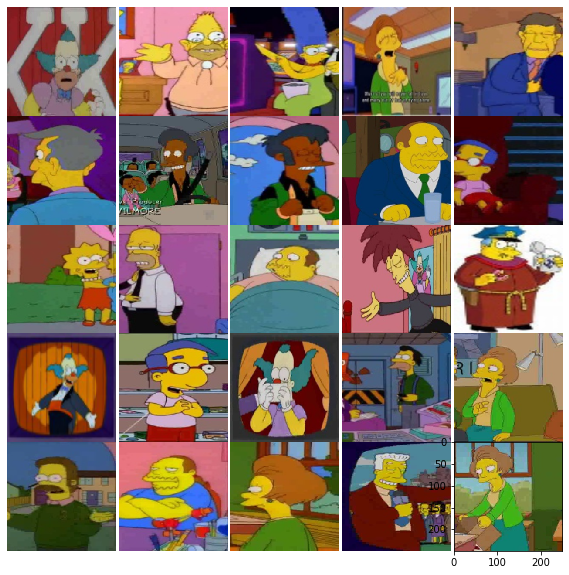

In [0]:
# Visualize images in the dataset
characters = glob.glob('simpsons-dataset/kaggle_simpson_testset/kaggle_simpson_testset/**')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)
i = 0
for character in characters[:25]:
    img = cv2.imread(character)
    img = cv2.resize(img, (250, 250))
    plt.axis('off')
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i += 1

In [0]:
# Define the labels for the Simpsons characters we're detecting
character_names = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
img_size = 64
num_classes = 20
dir = "simpsons-dataset/simpsons_dataset/simpsons_dataset"

# Load training data
X_train = []
y_train = []
for label, name in character_names.items():
   list_images = os.listdir(dir+'/'+name)
   for image_name in list_images:
       image = imageio.imread(dir+'/'+name+'/'+image_name)
       X_train.append(cv2.resize(image, (img_size,img_size)))
       y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Split data for cross validation  
X_train = X_train[:1000] 
y_train = y_train[:1000]

X_test = X_train[-100:] 
y_test = y_train[-100:]

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# One hot encode the labels (neural nets only like numbers)
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# Run A Sweep

As you'll recall there are just 3 simple steps to running a sweep:

**1. Define the sweep**

**2. Initialize the sweep**

**3. Run the sweep agent**

Let's walk through each step in more detail.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034183402_Screenshot+2019-10-25+13.09.37.png)

## 1. Define the Sweep

Weights & Biases sweeps give you powerful levers to configure your sweeps exactly how you want them, with just a few lines of code. The sweeps config can be defined as a dictionary or a [YAML file](https://docs.wandb.com/library/sweeps).

Let's walk through some of them together:
*   **Metric** – This is the metric the sweeps are attempting to optimize. Metrics can take a `name` (this metric should be logged by your training script) and a `goal` (maximize or minimize). 
*   **Search Strategy** – Specified using the 'method' variable. We support several different search strategies with sweeps. 
  *   **Grid Search** – Iterates over every combination of hyperparameter values.
  *   **Random Search** – Iterates over randomly chosen combinations of hyperparameter values.
  *   **Bayesian Search** – Creates a probabilistic model that maps hyperparameters to probability of a metric score, and chooses parameters with high probability of improving the metric. The objective of Bayesian optimization is to spend more time in picking the hyperparameter values, but in doing so trying out fewer hyperparameter values.
*   **Stopping Criteria** – The strategy for determining when to kill off poorly peforming runs, and try more combinations faster. We offer several custom scheduling algorithms like [HyperBand](https://arxiv.org/pdf/1603.06560.pdf) and Envelope.
*   **Parameters** – A dictionary containing the hyperparameter names, and discreet values, max and min values or distributions from which to pull their values to sweep over.

You can find a list of all configuration options [here](https://docs.wandb.com/library/sweeps/configuration).

### A Note To Advanced Users

Advanced users can modify sweep algorithms or write their own based on the W&B base classes `wandb.sweeps.base.Search` and `wandb.sweeps.base.EarlyTerminate`, which you can find in our [open source client library](https://github.com/wandb/client).

They can also create a [local controller](https://docs.wandb.com/library/sweeps/local-controller), which lets users take full control of search and stopping criteria, inspect and modify the code in order to debug issues as well as develop new features which can be incorporated into the cloud service.

In [0]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [10, 50, 100]
        },
        'batch_size': {
            'values': [256, 128, 64, 32]
        },
        'weight_decay': {
            'values': [0.0005, 0.005, 0.05]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        }
    }
}

## 2. Initialize the Sweep

In [0]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="sweep", project="simpsons")

Create sweep with ID: bfozkh0e
Sweep URL: https://app.wandb.ai/sweep/simpsons/sweeps/bfozkh0e


### Define Your Neural Network
Before we can run the sweep, let's define a function that creates and trains our neural network.

In the function below, we define a simplified version of a VGG19 model in Keras, and add the following lines of code to log models metrics, visualize performance and output and track our experiments easily:
*   **wandb.init()** – Initialize a new W&B run. Each run is single execution of the training script.
*   **wandb.config** – Save all your hyperparameters in a config object. This lets you use our app to sort and compare your runs by hyperparameter values.
*   **callbacks=[WandbCallback()]** – Fetch all layer dimensions, model parameters and log them automatically to your W&B dashboard.
*   **wandb.log()** – Logs custom objects – these can be images, videos, audio files, HTML, plots, point clouds etc. Here we use wandb.log to log images of Simpson characters overlaid with actual and predicted labels.

In [0]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [10, 20, 50]
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        },
        'conv_layer_size': {
            'values': [16, 32, 64]
        },
        'encoder_size': {
            'values': [128, 256, 512]
        },
        'decoder_size': {
            'values': [256, 512, 1024]
        },
        'weight_decay': {
            'values': [0.0005, 0.005, 0.05]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'activation': {
            'values': ['relu', 'elu', 'selu', 'softmax']
        },
        'layer': {
            'values': ['LSTM', 'GRU']
        }
    }
}
















In [0]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 2,
        'batch_size': 128,
        'weight_decay': 0.0005,
        'learning_rate': 1e-3,
        'activation': 'relu',
        'optimizer': 'nadam',
        'seed': 42
    }

    # Initilize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Determine input shape
    input_shape = (X_train.shape[1], X_train.shape[2], 3)
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # Set of Conv2D, Conv2D, MaxPooling2D layers with 32 and 64 filters
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Another set of Conv2D, Conv2D, MaxPooling2D layers with 128 filters
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Another set of Conv2D, Conv2D, MaxPooling2D layers with 256 filters
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Another set of Conv2D, Conv2D, MaxPooling2D layers with 512 filters
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Another set of Conv2D, Conv2D, MaxPooling2D layers with 512 filters
    model.add(Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten
    model.add(Flatten())
    model.add(Dense(512, activation ='relu', kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation = "softmax"))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(lr=config.learning_rate, decay=1e-5, momentum=0.9, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(lr=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    #data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)
    
    model.fit_generator(datagen.flow(X_train, y_train, batch_size=config.batch_size),
                        steps_per_epoch=len(X_train) / 32, epochs=config.epochs,
                        validation_data=(X_test, y_test),
                        callbacks=[WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=character_names),
                                   keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    predicted_images = []
    for i in range(20):
      character = character_names[i]
      # Read in a character image from the test dataset
      image = cv2.imread(np.random.choice([k for k in glob.glob('simpsons-dataset/kaggle_simpson_testset/kaggle_simpson_testset/*.*') if character in k]))
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
      # Resize image and normalize it
      pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
      
      # Get predictions for the character
      prediction = model.predict(pic.reshape(1, 64, 64,3))[0]
      
      # Get true name of the character
      name = character.split('_')[0].title()
      
      # Format predictions to string to overlay on image
      text = sorted(['{:s} : {:.1f}%'.format(character_names[k].split('_')[0].title(), 100*v) for k,v in enumerate(prediction)], 
         key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
      
      # Upscale image
      img = cv2.resize(img, (352, 352))
      
      # Create background to overlay text on
      cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
      
      # Add text to image
      font = cv2.FONT_HERSHEY_DUPLEX
      cv2.putText(img, 'True Name : %s' % name, (10, 280), font, 0.7,(73,79,183), 2, cv2.LINE_AA)
      for k, t in enumerate(text):
          cv2.putText(img, t, (10, 300+k*18), font, 0.65,(0,0,0), 2, cv2.LINE_AA)
          
      # Add predicted image from test dataset with annotations to array
      predicted_images.append(wandb.Image(img, caption="Actual: %s" % name))     
          
    # Log images from test set to wandb automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
    wandb.log({"predictions": predicted_images})

## 3. Run the sweep agent

In [0]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: qhzyiysj with config:
	batch_size: 128
	epochs: 100
	learning_rate: 0.001
	optimizer: sgd
	weight_decay: 0.05
wandb: Agent Started Run: qhzyiysj


Epoch 1/100
32/31 [==============================] - 18s 571ms/step - loss: 208.1772 - acc: 0.1782 - val_loss: 202.2435 - val_acc: 0.2900
Epoch 2/100
32/31 [==============================] - 8s 263ms/step - loss: 195.4176 - acc: 0.6672 - val_loss: 189.9604 - val_acc: 0.5700
Epoch 3/100
32/31 [==============================] - 8s 263ms/step - loss: 182.3787 - acc: 0.9039 - val_loss: 177.9252 - val_acc: 0.6500
Epoch 4/100
32/31 [==============================] - 8s 266ms/step - loss: 170.7165 - acc: 0.9417 - val_loss: 170.7456 - val_acc: 0.1800
Epoch 5/100
32/31 [==============================] - 8s 263ms/step - loss: 159.8565 - acc: 0.9722 - val_loss: 159.6783 - val_acc: 0.2200
Epoch 6/100
32/31 [==============================] - 8s 263ms/step - loss: 149.8787 - acc: 0.9744 - val_loss: 147.8720 - val_acc: 0.3800
Epoch 7/100
32/31 [==============================] - 8s 263ms/step - loss: 140.5229 - acc: 0.9801 - val_loss: 138.6446 - val_acc: 0.3300
Epoch 8/100
32/31 [=====================

# Visualize Predictions Live

## Project Overview
1. Check out the [project page](https://app.wandb.ai/sweep/simpsons) to see your results in the shared project. 
1. Press 'option+space' to expand the runs table, comparing all the results from everyone who has tried this script. 
1. Click on the name of a run to dive in deeper to that single run on its own run page.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034121760_Screenshot+2019-10-25+13.08.13.png)


## Visualize Sweep Results
Use a parallel coordinates chart to see which hyperparameter values led to the best accuracy.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034183402_Screenshot+2019-10-25+13.09.37.png)

We can tweak the slides in the parallel co-ordinates chart to only view the runs that led to the best accuracy values. This can help us hone in on ranges of hyperparameter values to sweep over next.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572035368646_Screenshot+2019-10-25+13.29.23.png)


## Visualize Performance
Click through to a single run to see more details about that run. For example, on [this run page](https://app.wandb.ai/sweep/simpsons/runs/adyi8vpr) you can see the performance metrics I logged when I ran this script.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034810322_Screenshot+2019-10-25+13.19.54.png)


## Visualize Predictions
You can visualize predictions made at everystep by clicking on the Media tab.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572035073411_Screenshot+2019-10-25+13.24.04.png)


## Review Code
The overview tab picks up a link to the code. In this case, it's a link to the Google Colab. If you're running a script from a git repo, we'll pick up the SHA of the latest git commit and give you a link to that version of the code in your own GitHub repo.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034739245_Screenshot+2019-10-25+13.18.45.png)

## Visualize System Metrics
The System tab on the runs page lets you visualize how resource efficient your model was. It lets you monitor the GPU, memory, CPU, disk, and network usage in one spot.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034693236_Screenshot+2019-10-25+13.17.16.png)


## Next Steps
As you can see running sweeps is super easy! We highly encourage you to fork this notebook, tweak the parameters, or try the model with your own dataset!


## More about Weights & Biases
We're always free for academics and open source projects. Email carey@wandb.com with any questions or feature suggestions. Here are some more resources:

1. [Documentation](http://docs.wandb.com) - Python docs
2. [Gallery](https://app.wandb.ai/gallery) - example reports in W&B
3. [Articles](https://www.wandb.com/articles) - blog posts and tutorials
4. [Community](bit.ly/wandb-forum) - join our Slack community forum